# Comm Pattern Characteristics

## Objectives

1. Analyze chracteristics of different comm. patterns.
2. Analyze distribution of key parameters of comm. patterns.


In [1]:
import numpy
import pickle
import os
import sys
import re
import seaborn as sns
import toyplot
import toyplot.svg
import pandas as pd

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib.pyplot as plt

## Load data

In [3]:
data = {
    "ascent_n4": pickle.load(file("data/cleaned/ascent-n4.pkl")),
    "moasp_n4": pickle.load(file("data/cleaned/moasp_n4.pkl")),
    "jsnts_s8_n4": pickle.load(file("data/cleaned/jsnts_s8_n4.pkl")),
    "jsnts_s16_n4": pickle.load(file("data/cleaned/jsnts_s16_n4.pkl")),
    "lareds_n4": pickle.load(file("data/cleaned/lareds-n4.pkl")),
    "lap3d_n4": pickle.load(file("data/cleaned/lap3d-n4.pkl")),
    "jemstd_n4": pickle.load(file("data/cleaned/jems_td-n4.pkl")),
    "ascent_n16": pickle.load(file("data/cleaned/ascent-n16.pkl")),
    "moasp_n16": pickle.load(file("data/cleaned/moasp_n16.pkl")),
    "jsnts_s8_n16": pickle.load(file("data/cleaned/jsnts_s8_n16.pkl")),
    "jsnts_s16_n16": pickle.load(file("data/cleaned/jsnts_s16_n16.pkl")),
    "lareds_n16": pickle.load(file("data/cleaned/lareds-n16.pkl")),
    "lap3d_n16": pickle.load(file("data/cleaned/lap3d-n16.pkl")),
    "jemstd_n16": pickle.load(file("data/cleaned/jems_td-n16.pkl"))    
}

In [4]:
def gather_patterns(data):
    result = set()
    for app, specs in data.iteritems():
        for group_id, spec in specs.iteritems():
            for pattern in spec["patterns"].iterkeys():
                result.add(pattern)
    return result

gather_patterns(data)

{'AllReduce', 'HaloExchange', 'OuterReduce', 'ParticleMigrate', 'Redistribute'}

## AllReduce Pattern

In [5]:
reduce_df = {"app": [], "reduce_id": [], "reduce_bytes": []}
for k, v in data.iteritems():
    v2 = v[0]
    if v2["reduces"]:
        for i, bytes in enumerate(v2["reduces"]):
            reduce_df["app"].append(k)
            reduce_df["reduce_id"].append(i)
            reduce_df["reduce_bytes"].append(bytes)
reduce_df = pd.DataFrame(reduce_df, columns=["app", "reduce_id", "reduce_bytes"])

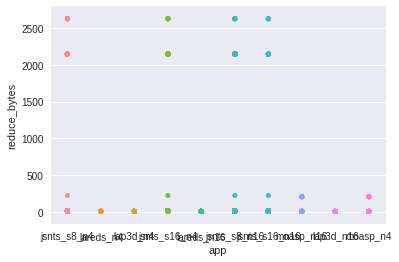

In [6]:
sns.stripplot(x="app", y="reduce_bytes", data=reduce_df, jitter=False)

From the above plot, we conclude that the sole parameter of AllReduce pattern, i.e., the message size is 8 bytes and 2KB. 8 bytes i used by all 5 applications and 2KB is used by 2 applications.

## Comm. Graph Analysis Utilities

In [7]:
import networkx

In [8]:
class DeviceMapper(object):
    def __init__(self, nsockets=2, cores_per_socket=12):
        self.nsockets = nsockets
        self.cores_per_socket = cores_per_socket
        self.cores_per_node = nsockets * cores_per_socket
    
    def proc_to_device(self, proc_id):
        return (proc_id / self.cores_per_node,
                proc_id % self.cores_per_node / self.cores_per_socket,
                proc_id % self.cores_per_node % self.cores_per_socket)

In [9]:
def compute_graphs(comm_graph, nnodes, socket_per_node=2, cores_per_socket=12):
    mapper = DeviceMapper(socket_per_node, cores_per_socket)
    nodes = range(nnodes)
    sockets = [(i, j) for i in nodes for j in xrange(socket_per_node)]
    cores = [(i, j, k) for i, j in sockets for k in xrange(cores_per_socket)]
    node_graph = networkx.MultiDiGraph()
    socket_graph = networkx.MultiDiGraph()
    core_graph = networkx.MultiDiGraph()
    node_graph.add_nodes_from(nodes)
    socket_graph.add_nodes_from(sockets)
    core_graph.add_nodes_from(cores)
    for t, msgsize in comm_graph.iteritems():
        # skip null messages
        if msgsize <= 0:
            continue
        start_proc = t[0]
        end_proc = t[3]
        # skip self loop because we only want to analyse the inter core communication
        if start_proc == end_proc:
            continue
        start_core = mapper.proc_to_device(start_proc)
        end_core = mapper.proc_to_device(end_proc)
        start_socket = tuple(start_core[:2])
        end_socket = tuple(end_core[:2])
        start_node = start_socket[0]
        end_node = end_socket[0]
        node_graph.add_edge(start_node, end_node, msgsize=msgsize)
        socket_graph.add_edge(start_socket, end_socket, msgsize=msgsize)
        core_graph.add_edge(start_core, end_core, msgsize=msgsize)
    return {
        "node_graph": node_graph,
        "socket_graph": socket_graph,
        "core_graph": core_graph
    }

### Graph Metric Calculating Utilities

1. Average number of messages per core, per socket, per node
2. Average number of neighbours per core, per socket, per node
3. Message size distribution
4. Message balance, per core, per socket, per node

In [10]:
# Compute neighbours and related metrics

def count_neighbours(G):
    G2 = G.to_undirected()
    result = {}
    for n in G2.nodes_iter():
        result[n] = len(G2.neighbors(n))
    return result

def compute_neighbour_metric(G):
    neighbours = count_neighbours(G)
    counts = neighbours.values()
    return {
        "median": numpy.median(counts),
        "mean": numpy.mean(counts),
        "std": numpy.std(counts),
        "max": numpy.max(counts),
        "min": numpy.min(counts)
    }

In [11]:
# Compute msgcount metrics, for example, average number of messages, average message size, etc.
def count_msgcount_balance(G):
    outdeg = G.out_degree()
    indeg = G.in_degree()
    diff = {k: v - indeg[k] for k, v in outdeg.iteritems()}
    return diff

def compute_msgcount_balance_metric(G):
    diff = count_msgcount_balance(G)
    balances = diff.values()
    return {
        "max": numpy.max(balances),
        "min": numpy.min(balances),
        "median": numpy.median(balances)
    }

def compute_msgcount_metric(G):
    counts = G.out_degree().values()
    return {
        "median": numpy.median(counts),
        "mean": numpy.mean(counts),
        "std": numpy.std(counts),
        "max": numpy.max(counts),
        "min": numpy.min(counts)
    }

def compute_msgsize_distribution(G):
    sizes = []
    for e in G.edges_iter(data=True):
        sizes.append(e[2]["msgsize"])
    return {
        "sizes": sizes,
        "median": numpy.median(sizes),
        "mean": numpy.mean(sizes),
        "std": numpy.std(sizes),
        "max": numpy.max(sizes),
        "min": numpy.min(sizes)
    }

In [12]:
# Compute message flow metrics

def compute_sending_bytes(G):
    result = {}
    for n in G.nodes():
        out_edges = G.out_edges(n, data=True)
        out_bytes = numpy.sum(x[2]["msgsize"] for x in out_edges)
        result[n] = out_bytes
    return result

def compute_recving_bytes(G):
    result = {}
    for n in G.nodes():
        in_edges = G.in_edges(n, data=True)
        in_bytes = numpy.sum(x[2]["msgsize"] for x in in_edges)
        result[n] = in_bytes
    return result

def compute_sending_metrics(G):
    bytes = compute_sending_bytes(G)
    bytes = bytes.values()
    return {
        "median": numpy.median(bytes),
        "mean": numpy.mean(bytes),
        "std": numpy.std(bytes),
        "max": numpy.max(bytes),
        "min": numpy.min(bytes)
    }

def compute_flow_balance_metrics(G):
    outs = compute_sending_bytes(G)
    ins = compute_recving_bytes(G)
    flow_diff = {k: v - ins[k] for k, v in outs.iteritems()}
    balances = flow_diff.values()
    return {
        "max": numpy.max(balances),
        "min": numpy.min(balances),
        "median": numpy.median(balances)
    }    

In [13]:
def merge_multi_digraph(G):
    G2 = networkx.DiGraph()
    G2.add_nodes_from(G.nodes())
    for u, v, d in G.edges_iter(data=True):
        if G2.has_edge(u, v):
            G2[u][v]["msgsize"] += d["msgsize"]
        else:
            G2.add_edge(u, v, msgsize=d["msgsize"])
    return G2

def compute_interobj_msgsize_distribution(G):
    G2 = merge_multi_digraph(G)
    return compute_msgsize_distribution(G2)

def compute_msgvolume(G):
    return numpy.sum(compute_msgsize_distribution(G)["sizes"])

In [14]:
def draw_graph(instance, pattern):
    app = instance["app"]
    nnodes = int(re.findall(r"n\d+$", app)[0][1:])
    fn = "{}-{}".format(pattern, app)
    G = compute_graphs(instance["comm_graph"], nnodes)["core_graph"]
    G2 = merge_multi_digraph(G).to_undirected()
    fig = plt.figure(figsize=(16, 12))
    networkx.draw_spring(G2, fig=fig)
    fig.savefig("{}.png".format(fn), transparent=True)

## HaloExchange Pattern

1. Scan all data for HaloExchange Comm. Graphs
2. Compute metrics of all Comm graphs: avg. number of neighbours, avg. number of messages, avg msgsize.

In [15]:
def select_comm_graph(data, pattern):
    instances = []
    for app, specs in data.iteritems():
        for group_id, spec in specs.iteritems():
            if pattern not in spec["patterns"]:
                continue
            for graph_id, counts in spec["patterns"][pattern].iteritems():
                instances.append({
                        "app": app,
                        "comm_graph": spec["comm_graphs"][graph_id],
                        "counts": counts
                    })
    return instances

In [16]:
def compute_basic_features(data, pattern):
    instances = select_comm_graph(data, pattern)
    app = []
    nodes = []
    avg_neibs = []
    avg_msgs = []
    avg_bytes = []
    avg_intercore_volume = []
    msg_volume = []
    for inst in instances:
        nnodes = int(re.findall(r"n\d+$", inst["app"])[0][1:])
        nodes.append(nnodes)
        graphs = compute_graphs(inst["comm_graph"], nnodes)
        core_graph = graphs["core_graph"]
        app.append(inst["app"])
        avg_neibs.append(compute_neighbour_metric(core_graph)["mean"])
        avg_msgs.append(compute_msgcount_metric(core_graph)["mean"])
        avg_bytes.append(compute_msgsize_distribution(core_graph)["mean"])
        avg_intercore_volume.append(compute_interobj_msgsize_distribution(core_graph)["mean"])
        msg_volume.append(compute_msgvolume(core_graph))
    result_data = {
        "app": app,
        "nnodes": nodes,
        "avg_neibs": avg_neibs,
        "avg_msgs": avg_msgs,
        "avg_bytes": avg_bytes,
        "avg_intercore_volume": avg_intercore_volume,
        "msg_volume": msg_volume
    }
    return pd.DataFrame(result_data,
                        columns=["app", "nnodes", "avg_neibs", "avg_msgs",
                                 "avg_bytes", "avg_intercore_volume", "msg_volume"])

In [17]:
def compute_halo_exchange_features(data):
    return compute_basic_features(data, "HaloExchange")

In [18]:
features = compute_halo_exchange_features(data)

In [19]:
features["best_time"] = features["avg_intercore_volume"] / 6e3
features["worst_time"] = features["msg_volume"] / 12e3

In [20]:
features.to_pickle("halo_exchange_features_summary.pkl")
features.sort_values(["nnodes", "app"])

,app,nnodes,avg_neibs,avg_msgs,avg_bytes,avg_intercore_volume,msg_volume,best_time,worst_time
28,ascent_n4,4,24.000000,48.000000,34624.000000,69248.000000,159547392,11.541333,13295.616000
29,ascent_n4,4,24.000000,24.000000,34624.000000,34624.000000,79773696,5.770667,6647.808000
30,ascent_n4,4,24.000000,24.000000,34624.000000,34624.000000,79773696,5.770667,6647.808000
31,ascent_n4,4,24.000000,24.000000,34624.000000,34624.000000,79773696,5.770667,6647.808000
32,jemstd_n4,4,15.666667,62.666667,65308.297872,261233.191489,392894720,43.538865,32741.226667
33,jemstd_n4,4,15.666667,15.666667,195924.893617,195924.893617,294671040,32.654149,24555.920000
34,jemstd_n4,4,15.666667,15.666667,195924.893617,195924.893617,294671040,32.654149,24555.920000
35,jemstd_n4,4,15.666667,15.666667,195924.893617,195924.893617,294671040,32.654149,24555.920000
36,jemstd_n4,4,15.666667,15.666667,195924.893617,195924.893617,294671040,32.654149,24555.920000
15,jsnts_s16_n4,4,10.895833,65.375000,868.038241,5208.229446,5447808,0.868038,453.984000


/home/zyang/.local/pip/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/zyang/.local/pip/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/zyang/.local/pip/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/zyang/.local/pip/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold i

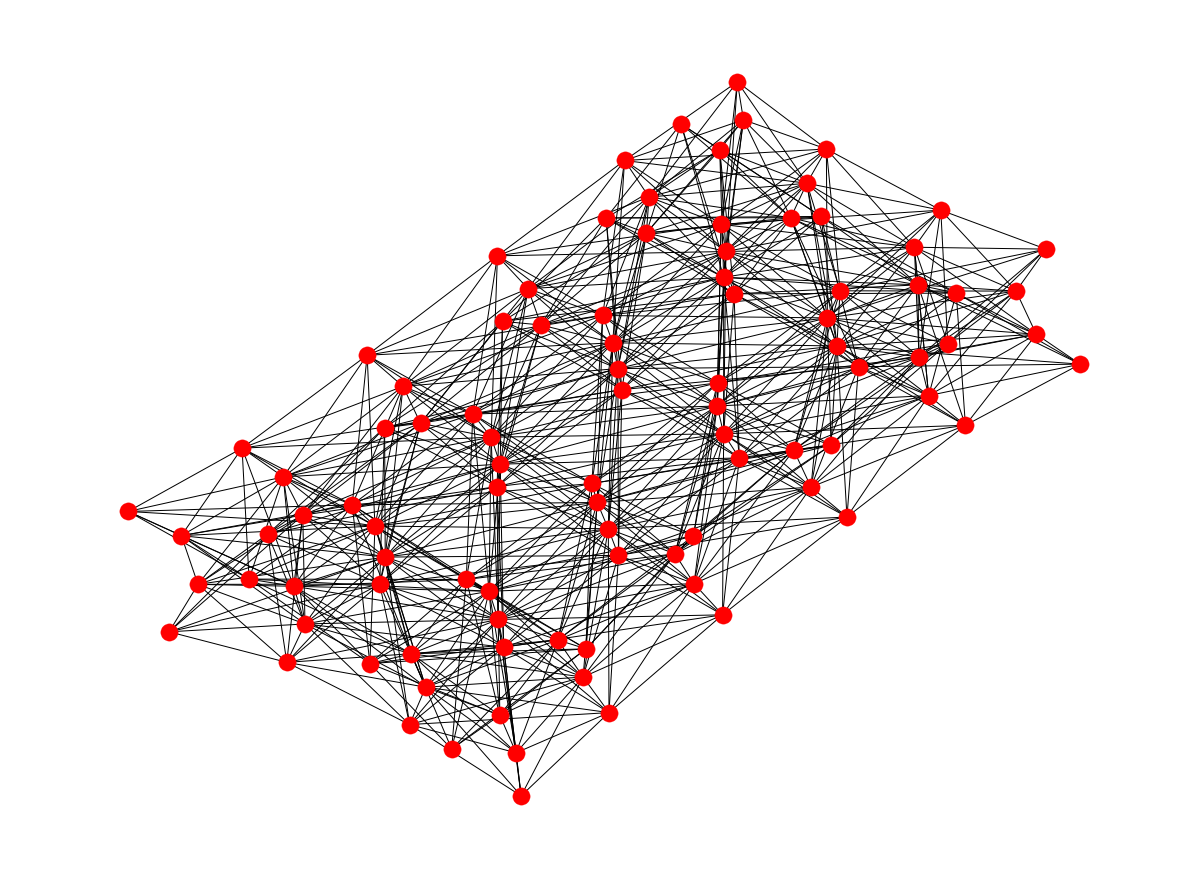

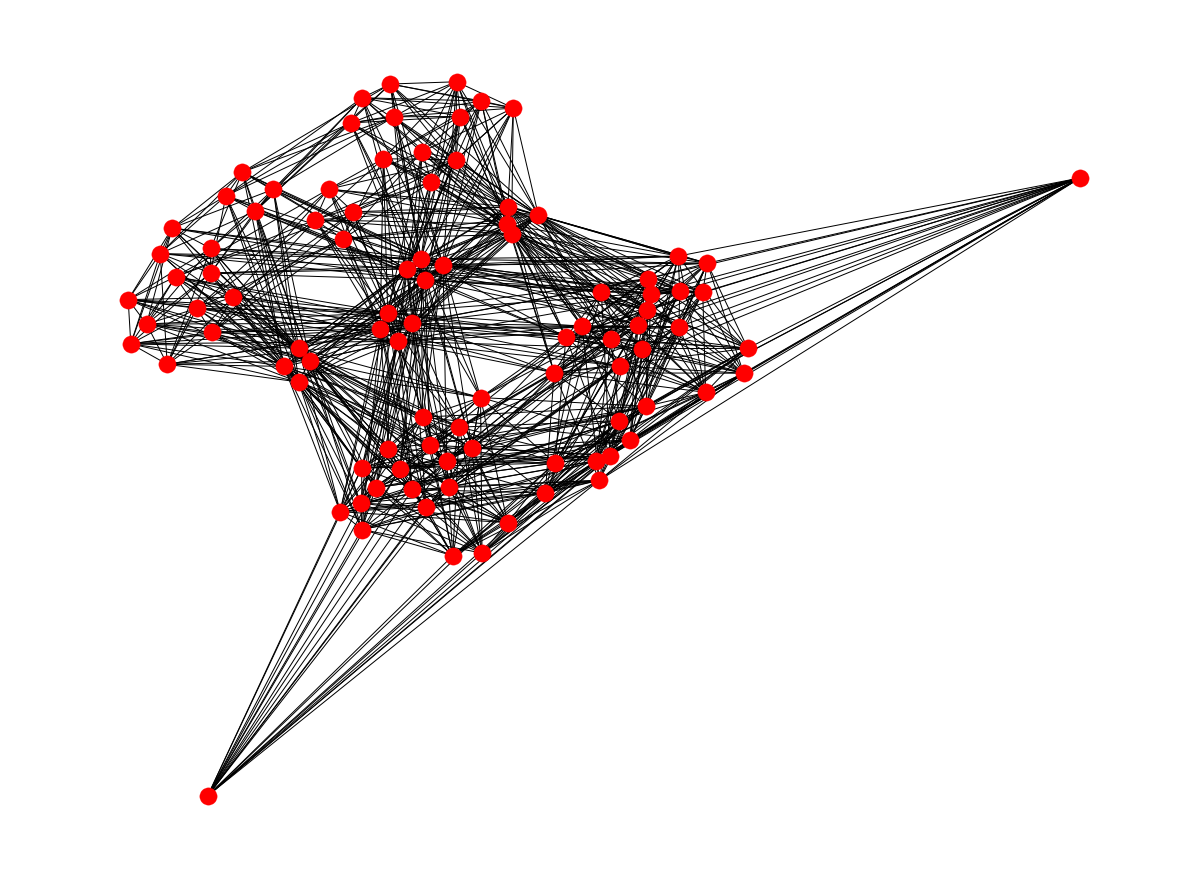

In [21]:
instances = select_comm_graph(data, "HaloExchange")
draw_graph(instances[1], "HaloExchange")
draw_graph(instances[11], "HaloExchange")

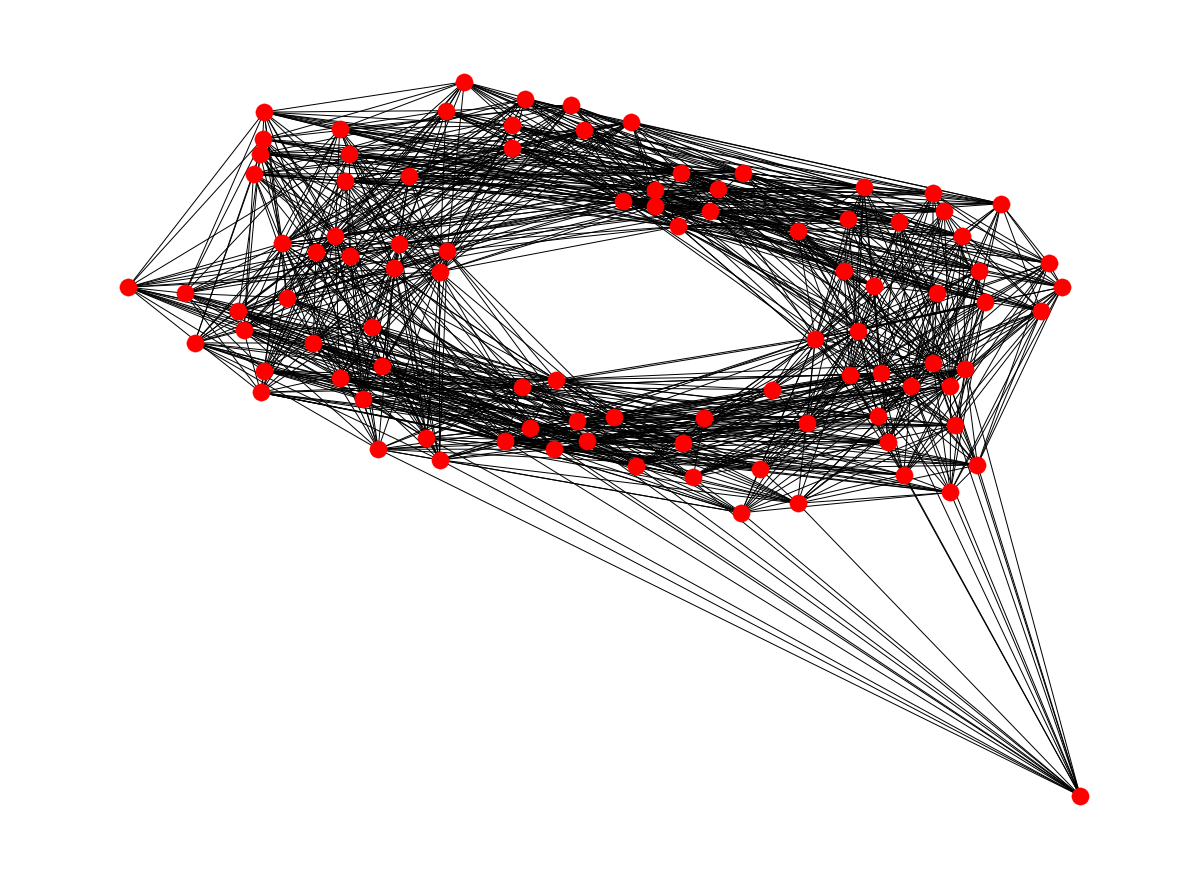

In [22]:
draw_graph(instances[29], "HaloExchange")

In [23]:
def draw_graph_adjecency_matrix(instance, reorder=None):
    cg = compute_graphs(instance["comm_graph"], 4)["core_graph"]
    nodes = None
    if reorder:
        nodes = reorder(cg)
    spectrum = networkx.laplacian_spectrum(cg.to_undirected(), weight="msgsize")
    nodes = cg.nodes()
    spectrum_map = zip(nodes, spectrum)
    spectrum_map.sort(key=lambda x: x[1])
    nodes = [x[0] for x in spectrum_map]
    mat = networkx.to_numpy_matrix(cg, nodelist=nodes, weight="msgsize")
    plt.matshow(mat)
    app = instance["app"]
    nnodes = int(re.findall(r"n\d+$", app)[0][1:])
    fn = "{}-{}".format("HaloExchange", app)
    plt.savefig("{}-adjmat.png".format(fn), transparent=True)


In [24]:
def reorder_degree(G):
    node_degree = [(node, G.degree(node)) for node in G.nodes_iter()]
    node_degree.sort(key=lambda x: x[1])
    return [x[0] for x in node_degree]

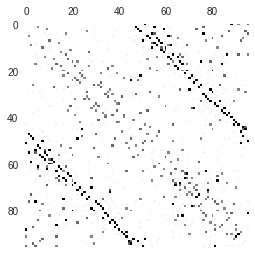

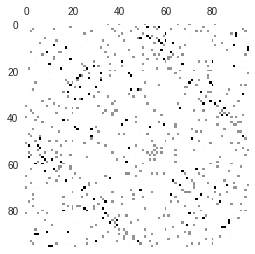

In [25]:
#draw_graph_adjecency_matrix(instances[29], reorder=lambda x: networkx.spectral_ordering(x))
#draw_graph_adjecency_matrix(instances[1], reorder=lambda x: networkx.spectral_ordering(x))
draw_graph_adjecency_matrix(instances[1], reorder=networkx.spectral_ordering)
draw_graph_adjecency_matrix(instances[11], reorder=networkx.spectral_ordering)

## ParticleMigrate Pattern

In [26]:
features = compute_basic_features(data, "ParticleMigrate")
features.sort_values("nnodes")

,app,nnodes,avg_neibs,avg_msgs,avg_bytes,avg_intercore_volume,msg_volume
1,ascent_n4,4,24.0,24.0,154294.208333,154294.208333,355493856
3,moasp_n4,4,19.5,19.5,2256.239316,2256.239316,4223680
0,ascent_n16,16,24.0,24.0,69286.578993,69286.578993,638545112
2,moasp_n16,16,19.5,19.5,1014.940171,1014.940171,7599872


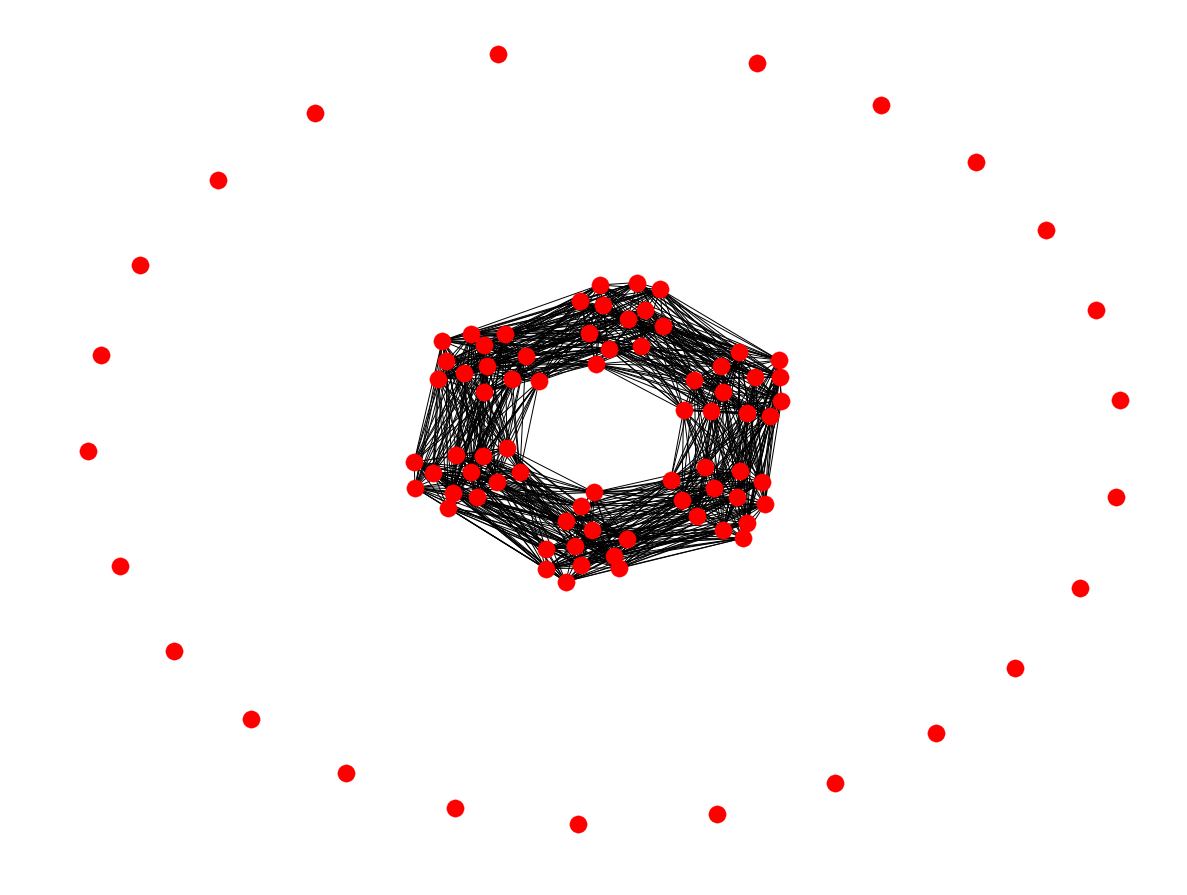

In [27]:
instances = select_comm_graph(data, "ParticleMigrate")
draw_graph(instances[3], "ParticleMigrate")

## Redistribute Pattern

In [28]:
features = compute_basic_features(data, "Redistribute")
features.sort_values("nnodes")

,app,nnodes,avg_neibs,avg_msgs,avg_bytes,avg_intercore_volume,msg_volume
0,jsnts_s8_n4,4,1.979167,2.968750,110616.589474,331849.768421,31525728
1,jsnts_s8_n4,4,1.979167,0.989583,964346.021053,964346.021053,91612872
2,jsnts_s16_n4,4,1.979167,2.968750,110616.589474,331849.768421,31525728
3,jsnts_s16_n4,4,1.979167,0.989583,964346.021053,964346.021053,91612872
4,jsnts_s8_n16,16,1.994792,2.992188,29424.584856,88273.754569,33808848
5,jsnts_s8_n16,16,1.994792,0.997396,241169.483029,241169.483029,92367912
6,jsnts_s16_n16,16,1.994792,2.992188,29424.584856,88273.754569,33808848
7,jsnts_s16_n16,16,1.994792,0.997396,241169.483029,241169.483029,92367912


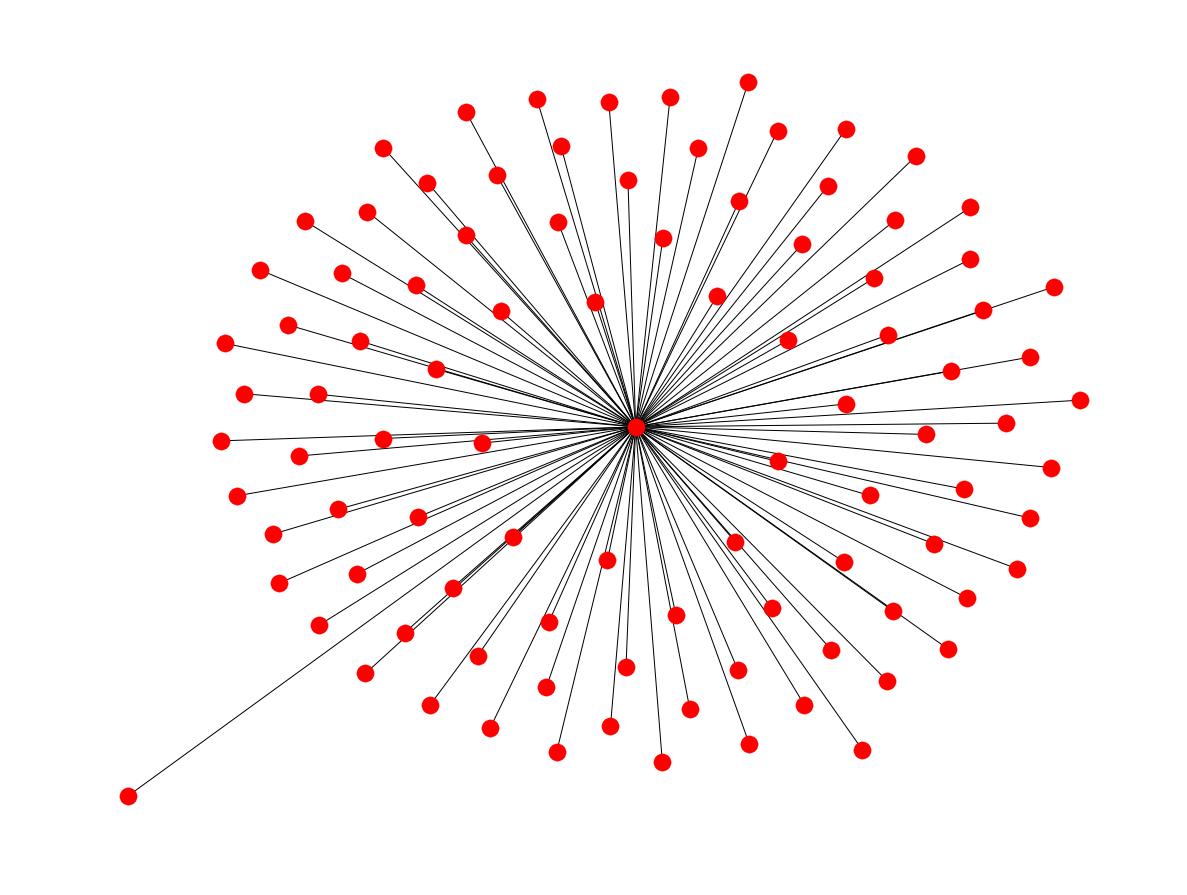

In [29]:
instances = select_comm_graph(data, "Redistribute")
draw_graph(instances[1], "Redistribute")

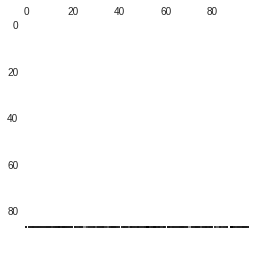

In [30]:
draw_graph_adjecency_matrix(instances[1])